# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [2]:
import warnings
# warnings.filterwarnings('ignore')

In [258]:
import pandas as pd
import patsy
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Getting data

In [4]:
file_name = '../csvs/element_gameweek_features_v03.csv'

In [5]:
element_gameweek_df = pd.read_csv(file_name)

In [6]:
current_event = 20

In [7]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [8]:
element_gameweek_df.fillna(3, inplace=True)

In [9]:
element_gameweek_df.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_against_opposition_team_element_type,rolling_avg_total_points_home,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground
0,cech,1,1,1,1,13,1,1,50,1,...,3.0,3.0,3.0,3.0,3.0,3,3.000000,3.000000,3.000000,3.0
1,cech,1,2,14,1,6,0,1,50,0,...,3.0,3.0,3.0,3.0,3.0,3,0.681818,3.000000,3.000000,3.0
2,cech,1,3,21,1,19,1,1,50,0,...,8.0,3.0,3.0,3.0,3.0,3,3.750000,0.000000,3.000000,3.0
3,cech,1,4,33,1,5,0,1,50,1,...,11.0,3.0,3.0,6.0,3.0,1,4.493304,0.000000,4.901786,3.0
4,cech,1,5,46,1,15,0,1,50,0,...,49.0,3.0,0.0,2.0,0.0,2,3.663651,5.929855,1.332237,0.0


In [10]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [13]:
last_train_event = 15

In [14]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [15]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [16]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'total_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_var_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_total_points_element_type',
 'roll

In [17]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [19]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'rolling_avg_attempted_passes_element',
     'rolling_var_total_points_against_opposition_team',
     'rolling_var_total_points_own_team',
     'rolling_var_total_points_opposition_team',
     'rolling_var_total_points_element_type',
     'rolling_var_total_points_against_opposition_team_element_type',
     'expected_var_total_points_against_opposition_team',
     'expected_var_total_points_at_ground',
     'rolling_avg_total_points_home',
     'rolling_var_total_points_home',
     'rolling_avg_total_points_against_opposition_ground_element_type',
     'rolling_var_total_points_against_opposition_ground_element_type',
     'total_points'
 ]])

In [20]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + value + is_sunday + is_weekday + is_late + is_early + rolling_avg_total_points_element + rolling_var_total_points_element + rolling_max_total_points_element + rolling_avg_minutes_element_p3 + rolling_avg_bps_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolli

In [21]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [243]:
X.shape

(3644, 435)

In [22]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

### Linear regression

In [23]:
lr_estimator = LinearRegression()
lr_selector = RFECV(lr_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lr_selector.fit(X, y.ravel())

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
F

Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
F

Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [244]:
lr_features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
lr_selected_features = pd.Series(lr_features)[lr_selector.support_]
list(lr_selected_features)

['C(element)[T.183]',
 'C(element)[T.189]',
 'C(element)[T.511]',
 'C(element)[T.512]']

In [26]:
lr_X_sel = X[:,lr_selector.support_]
lr_X_train_sel = X_train[:,lr_selector.support_]
lr_X_test_sel = X_test[:,lr_selector.support_]

### Ridge regression (lush)

In [122]:
lush_ridge_estimator = Ridge(alpha=25)
lush_ridge_selector = RFECV(lush_ridge_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lush_ridge_selector.fit(X, y.ravel())

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
F

Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.
Fitting estimator with 393 features.
Fitting estimator with 392 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [246]:
lush_ridge_features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
lush_ridge_selected_features = pd.Series(lush_ridge_features)[lush_ridge_selector.support_]
list(lush_ridge_selected_features)

['C(element)[T.4]',
 'C(element)[T.6]',
 'C(element)[T.12]',
 'C(element)[T.14]',
 'C(element)[T.18]',
 'C(element)[T.22]',
 'C(element)[T.23]',
 'C(element)[T.24]',
 'C(element)[T.27]',
 'C(element)[T.28]',
 'C(element)[T.33]',
 'C(element)[T.37]',
 'C(element)[T.39]',
 'C(element)[T.40]',
 'C(element)[T.43]',
 'C(element)[T.48]',
 'C(element)[T.49]',
 'C(element)[T.50]',
 'C(element)[T.54]',
 'C(element)[T.56]',
 'C(element)[T.58]',
 'C(element)[T.60]',
 'C(element)[T.61]',
 'C(element)[T.62]',
 'C(element)[T.69]',
 'C(element)[T.71]',
 'C(element)[T.73]',
 'C(element)[T.75]',
 'C(element)[T.76]',
 'C(element)[T.77]',
 'C(element)[T.79]',
 'C(element)[T.80]',
 'C(element)[T.82]',
 'C(element)[T.84]',
 'C(element)[T.85]',
 'C(element)[T.88]',
 'C(element)[T.90]',
 'C(element)[T.91]',
 'C(element)[T.94]',
 'C(element)[T.95]',
 'C(element)[T.98]',
 'C(element)[T.99]',
 'C(element)[T.101]',
 'C(element)[T.102]',
 'C(element)[T.106]',
 'C(element)[T.110]',
 'C(element)[T.115]',
 'C(elemen

In [124]:
lush_ridge_X_sel = X[:,lush_ridge_selector.support_]
lush_ridge_X_train_sel = X_train[:,lush_ridge_selector.support_]
lush_ridge_X_test_sel = X_test[:,lush_ridge_selector.support_]

### Ridge regression (stark)

In [183]:
stark_ridge_estimator = Ridge(alpha=10)
stark_ridge_selector = RFECV(stark_ridge_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
stark_ridge_selector.fit(X, y.ravel())

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
F

Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.
Fitting estimator with 393 features.
F

Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [247]:
stark_ridge_features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
stark_ridge_selected_features = pd.Series(stark_ridge_features)[stark_ridge_selector.support_]
list(stark_ridge_selected_features)

['C(element)[T.40]',
 'C(element)[T.43]',
 'C(element)[T.49]',
 'C(element)[T.69]',
 'C(element)[T.91]',
 'C(element)[T.115]',
 'C(element)[T.116]',
 'C(element)[T.122]',
 'C(element)[T.134]',
 'C(element)[T.172]',
 'C(element)[T.221]',
 'C(element)[T.234]',
 'C(element)[T.245]',
 'C(element)[T.246]',
 'C(element)[T.247]',
 'C(element)[T.262]',
 'C(element)[T.295]',
 'C(element)[T.301]',
 'C(element)[T.306]',
 'C(element)[T.333]',
 'C(element)[T.356]',
 'C(element)[T.364]',
 'C(element)[T.365]',
 'C(element)[T.391]',
 'C(element)[T.411]',
 'C(element)[T.423]',
 'C(element)[T.425]',
 'C(element)[T.437]',
 'C(element)[T.462]',
 'C(element)[T.465]',
 'C(element)[T.484]',
 'C(element_type)[T.2]',
 'C(element_type)[T.3]',
 'C(element_type)[T.4]',
 'C(opposition_team)[T.9]',
 'C(opposition_team)[T.12]',
 'C(opposition_team)[T.13]',
 'value']

In [185]:
stark_ridge_X_sel = X[:,stark_ridge_selector.support_]
stark_ridge_X_train_sel = X_train[:,stark_ridge_selector.support_]
stark_ridge_X_test_sel = X_test[:,stark_ridge_selector.support_]

### Lasso regression

In [255]:
lasso_estimator = Lasso(alpha=25)
lasso_selector = RFECV(lasso_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lasso_selector.fit(X, y.ravel())

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
F

Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.
Fitting estimator with 393 features.
Fitting estimator with 392 features.
Fitting estimator with 391 features.
Fitting estimator with 390 features.
F

Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Lasso(alpha=25, copy_X=True, fit_intercept=True, max_iter=1000,
                      normalize=False, positive=False, precompute=False,
                      random_state=None, selection='cyclic', tol=0.0001,
                      warm_start=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [256]:
lasso_features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
lasso_selected_features = pd.Series(lasso_features)[lasso_selector.support_]
list(lasso_selected_features)

['expected_avg_total_points_at_ground']

In [257]:
lasso_X_sel = X[:,lasso_selector.support_]
lasso_X_train_sel = X_train[:,lasso_selector.support_]
lasso_X_test_sel = X_test[:,lasso_selector.support_]

## Tuning model

### GP tuner

#### Ridge regression (lush)

In [128]:
lush_ridge_space  = [Real(10**0, 10**3, 'log-uniform', name='alpha')]

In [129]:
lush_ridge_gp_model = Ridge()

@use_named_args(lush_ridge_space)
def lush_ridge_objective(**params):
    lush_ridge_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lush_ridge_gp_model,
            lush_ridge_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [130]:
lush_ridge_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    lush_ridge_res_gp = gp_minimize(lush_ridge_objective, lush_ridge_space, n_calls=30, verbose=2)
    lush_ridge_res_gp_arr.append(lush_ridge_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0862
Function value obtained: 9.4872
Current minimum: 9.4872
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0842
Function value obtained: 9.3477
Current minimum: 9.3477
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0756
Function value obtained: 9.3635
Current minimum: 9.3477
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0635
Function value obtained: 9.6314
Current minimum: 9.3477
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0714
Function value obtained: 9.3527
Current minimum: 9.3477
Iteration 

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.3856
Function value obtained: 9.3394
Current minimum: 9.3394
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.5374
Function value obtained: 9.3392
Current minimum: 9.3392
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.4943
Function value obtained: 9.3405
Current minimum: 9.3392
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.5205
Function value obtained: 9.3393
Current minimum: 9.3392
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.5956
Function value obtained: 9.3423
Current minimum: 9.3392
Iteration No: 17 started. Sea

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.5923
Function value obtained: 9.3430
Current minimum: 9.3392
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.6452
Function value obtained: 9.3393
Current minimum: 9.3392
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5541
Function value obtained: 9.3392
Current minimum: 9.3392
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.6731
Function value obtained: 9.3464
Current minimum: 9.3392
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.6064
Function value obtained: 9.3437
Current minimum: 9.3392
Iteration No: 28 started. Sea

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.0659
Function value obtained: 9.4423
Current minimum: 9.3399
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.0763
Function value obtained: 9.3637
Current minimum: 9.3399
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.0568
Function value obtained: 9.3741
Current minimum: 9.3399
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.0570
Function value obtained: 9.5450
Current minimum: 9.3399
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.6388
Function value obtained: 9.5468
Current minimum: 9.3399
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 11 ended. Search 

In [131]:
for i in lush_ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in lush_ridge_res_gp_arr:
    print(i.x)

9.3392379206756
9.339237706035918
9.3392375269318
9.339237298229072
9.339237158371807


[273.1444489163946]
[270.17288010634735]
[272.65918971553225]
[272.2384283638081]
[271.6950539284991]


#### Ridge regression (stark)

In [194]:
stark_ridge_space  = [Real(10**-8, 10**0, 'log-uniform', name='alpha')]

In [195]:
stark_ridge_gp_model = Ridge()

@use_named_args(stark_ridge_space)
def stark_ridge_objective(**params):
    stark_ridge_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            stark_ridge_gp_model,
            stark_ridge_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [196]:
stark_ridge_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    stark_ridge_res_gp = gp_minimize(stark_ridge_objective, stark_ridge_space, n_calls=30, verbose=2)
    stark_ridge_res_gp_arr.append(stark_ridge_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0269
Function value obtained: 9.1345
Current minimum: 9.1345
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0097
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0143
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0128
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0117
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.3842
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 13 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.3342
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 14 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3787
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3010
Function value obtained: 9.1494
Current minimum: 9.1344
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3951
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4877
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.5339
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 19 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4952
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.5833
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5477
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5607
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5832
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 27 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5523
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5497
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5300
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4658
Function value obtained: 9.1344
Current minimum: 9.1344
minimisation iteration 2
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0140
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 2 st

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.3981
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 13 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.3559
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3595
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 15 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4468
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4210
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3221
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3739
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4416
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 20 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3955
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4431
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4540
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 23 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4789
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5108
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.6265
Function value obtained: 9.1494
Current minimum: 9.1344
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.6067
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5258
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4373
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 29 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.2931
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 13 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.3171
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 14 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3321
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3257
Function value obtained: 9.1494
Current minimum: 9.1344
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3497
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.5073
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.4304
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 19 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3215
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 21 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4186
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4696
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3382
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4435
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3818
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 26 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4184
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5797
Function value obtained: 9.1494
Current minimum: 9.1344
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5355
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4906
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5332
Function value obtained: 9.1344
Current minimum: 9.1344
minimisation iteration 4
Iter

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.3665
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 14 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3625
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 15 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3788
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4252
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 17 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4292
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.4504
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4415
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5360
Function value obtained: 9.1494
Current minimum: 9.1344
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4125
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4814
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4817
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 24 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4888
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5478
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 28 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5338
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4974
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5740
Function value obtained: 9.1344
Current minimum: 9.1344
minimisation iteration 5
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0222
Function value obtained: 9.1444
Current minimum: 9.1444
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0101
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 3 started. Evaluat

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.3061
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 13 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.3197
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 14 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3266
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 15 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3989
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3877
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4149
Function value obtained: 9.1493
Current minimum: 9.1344
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.5525
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4425
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4737
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 21 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5401
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4950
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5197
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.6059
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 29 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5184
Function value obtained: 9.1344
Current minimum: 9.1344
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5168
Function value obtained: 9.1344
Current minimum: 9.1344


In [197]:
for i in stark_ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in stark_ridge_res_gp_arr:
    print(i.x)

9.13436992333015
9.13436992333015
9.13436992333015
9.13436992333015
9.13436992333015


[1e-08]
[1e-08]
[1e-08]
[1e-08]
[1e-08]


#### Lasso regression

In [75]:
lasso_space  = [Real(10**-7, 10**-3, 'log-uniform', name='alpha')]

In [76]:
lasso_gp_model = Lasso()

@use_named_args(lasso_space)
def lasso_objective(**params):
    lasso_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lasso_gp_model,
            lasso_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [77]:
lasso_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    lasso_res_gp = gp_minimize(lasso_objective, lasso_space, n_calls=30, verbose=2)
    lasso_res_gp_arr.append(lasso_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0037
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0034
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0033
Function value obtained: 9.9541
Current minimum: 9.9538
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0034
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0034
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.4561
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.5658
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4401
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3452
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3670
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3338
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 20 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3767
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3591
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3771
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 23 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.5176
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5815
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7290
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.6321
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5836
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 28 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5581
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 29 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.7052
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 30 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5647
Function value obtained: 9.9538
Current minimum: 9.9538
minimisation iteration 2
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0037
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0032
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0032
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0032
Function value obtained: 9.9539
Current minimum: 9.9538
Iteration No: 5 started. Evaluating function at random point

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.5809
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3616
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3874
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3294
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 20 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3756
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3309
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3595
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 23 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3281
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3335
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4357
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 26 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.8058
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.7613
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 28 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.6469
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4611
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 30 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3924
Function value obtained: 9.9538
Current minimum: 9.9538
minimisation iteration 3
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0038
Function value obtained: 9.9539
Current minimum: 9.9539
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0033
Function value obtained: 9.9539
Current minimum: 9.9539
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0032
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0032
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 5 started. Evaluating function at random point

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.2882
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 14 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3876
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2723
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4694
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.6346
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.6203
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.5335
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3991
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2995
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3338
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 23 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4035
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4039
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4423
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4453
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 27 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.6251
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.7326
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 29 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5399
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 30 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5613
Function value obtained: 9.9538
Current minimum: 9.9538
minimisation iteration 4
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0058
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0045
Function value obtained: 9.9539
Current minimum: 9.9538
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0045
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0045
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 5 started. Evaluating function at random point

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3651
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3479
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2679
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3580
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.6520
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4846
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 21 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.6017
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4639
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 23 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4297
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3708
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3798
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 26 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4229
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4293
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4525
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 29 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.7403
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 30 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.7177
Function value obtained: 9.9538
Current minimum: 9.9538
minimisation iteration 5
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0082
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0024
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0035
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0034
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 5 started. Evaluating function at random point

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.2675
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.2623
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 15 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3498
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3405
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3070
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3203
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3912
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.7080
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 21 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.6677
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4430
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 23 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4066
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5051
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3978
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3960
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 27 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3991
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 28 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4788
Function value obtained: 9.9538
Current minimum: 9.9538
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5260
Function value obtained: 9.9543
Current minimum: 9.9538
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.8098
Function value obtained: 9.9543
Current minimum: 9.9538


In [78]:
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

9.953815614072568
9.953815614072568
9.953815614072568
9.953815614072568
9.953815614072568


[1e-07]
[1e-07]
[1e-07]
[1e-07]
[1e-07]


# Evaluating model

## Linear regression

In [154]:
lr_model = LinearRegression()
lr_model.fit(lr_X_train_sel, y_train.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [260]:
# get predictions for test set
lr_y_pred = lr_model.predict(lr_X_test_sel).flatten()

# calculate cross entropy loss for test set
lr_test_loss = (
    mean_absolute_error(y_test, lr_y_pred),
    mean_squared_error(y_test, lr_y_pred),
    r2_score(y_test, lr_y_pred)
)
lr_test_loss

(2.3683391813968693, 10.41021402126814, -0.0003260018409498855)

In [156]:
pd.Series(lr_y_pred).describe()

count    9.480000e+02
mean     2.891580e+00
std      4.443236e-16
min      2.891580e+00
25%      2.891580e+00
50%      2.891580e+00
75%      2.891580e+00
max      2.891580e+00
dtype: float64

In [157]:
# refit lr_model on all data
lr_model_full = LinearRegression()
lr_model_full.fit(lr_X_sel, y.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [261]:
# get predictions for whole set
lr_y_pred_full = lr_model_full.predict(lr_X_sel).flatten()

# calculate cross entropy loss for test set
lr_test_loss_full = (
    mean_absolute_error(y, lr_y_pred_full),
    mean_squared_error(y, lr_y_pred_full),
    r2_score(y, lr_y_pred_full)
)
lr_test_loss_full

(2.2871797688058546, 9.551606696284125, 0.001771472042882416)

In [159]:
pd.Series(lr_y_pred_full).describe()

count    3.644000e+03
mean     2.869374e+00
std      1.302117e-01
min      2.220446e-15
25%      2.877410e+00
50%      2.877410e+00
75%      2.877410e+00
max      2.877410e+00
dtype: float64

In [160]:
abs(pd.Series(y.ravel()) - pd.Series(lr_y_pred_full)).describe()

count    3.644000e+03
mean     2.287180e+00
std      2.078846e+00
min      2.220446e-15
25%      8.774105e-01
50%      1.877410e+00
75%      2.877410e+00
max      1.812259e+01
dtype: float64

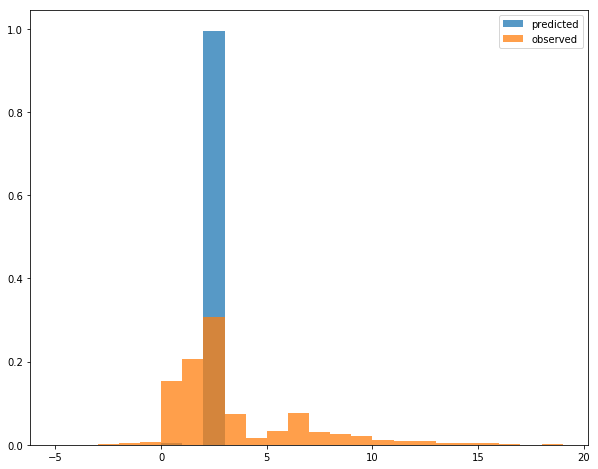

In [238]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lr_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

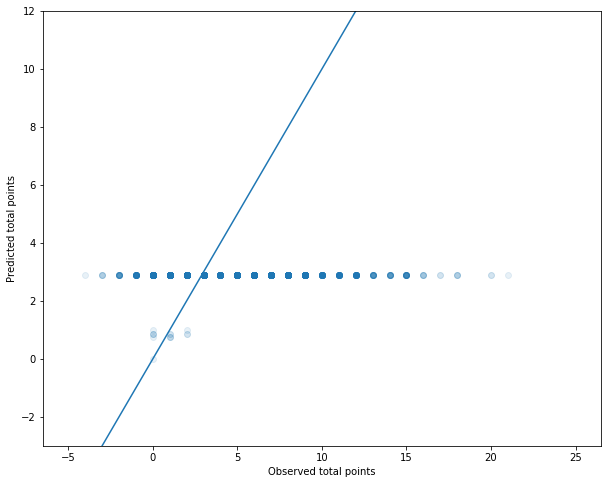

In [163]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(lr_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Ridge regression (lush)

In [145]:
lush_ridge_model = Ridge(alpha=270)
lush_ridge_model.fit(lush_ridge_X_train_sel, y_train.ravel())

Ridge(alpha=270, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [262]:
# get predictions for test set
lush_ridge_y_pred = lush_ridge_model.predict(lush_ridge_X_test_sel).flatten()

# calculate cross entropy loss for test set
lush_ridge_test_loss = (
    mean_absolute_error(y_test, lush_ridge_y_pred),
    mean_squared_error(y_test, lush_ridge_y_pred),
    r2_score(y_test, lush_ridge_y_pred),
)
lush_ridge_test_loss

(2.191359770437065, 9.33923785632501, 0.10258497606553607)

In [165]:
pd.Series(lush_ridge_y_pred).describe()

count    948.000000
mean       2.759182
std        0.903117
min        0.493788
25%        2.138403
50%        2.687158
75%        3.268725
max        6.782840
dtype: float64

In [168]:
# refit lush_ridge_model on all data
lush_ridge_model_full = Ridge(alpha=270)
lush_ridge_model_full.fit(lush_ridge_X_sel, y.ravel())

Ridge(alpha=270, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [263]:
# get predictions for whole set
lush_ridge_y_pred_full = lush_ridge_model_full.predict(lush_ridge_X_sel).flatten()

# calculate cross entropy loss for test set
lush_ridge_test_loss_full = (
    mean_absolute_error(y, lush_ridge_y_pred_full),
    mean_squared_error(y, lush_ridge_y_pred_full),
    r2_score(y, lush_ridge_y_pred_full)
)
lush_ridge_test_loss_full

(2.1133078616621717, 8.380949713010818, 0.12411562149474886)

In [170]:
pd.Series(lush_ridge_y_pred_full).describe()

count    3644.000000
mean        2.869374
std         0.964578
min         0.399631
25%         2.218457
50%         2.768864
75%         3.376497
max         7.562565
dtype: float64

In [171]:
abs(pd.Series(y.ravel()) - pd.Series(lush_ridge_y_pred_full)).describe()

count    3644.000000
mean        2.113308
std         1.978877
min         0.000040
25%         0.809295
50%         1.636287
75%         2.739124
max        15.110518
dtype: float64

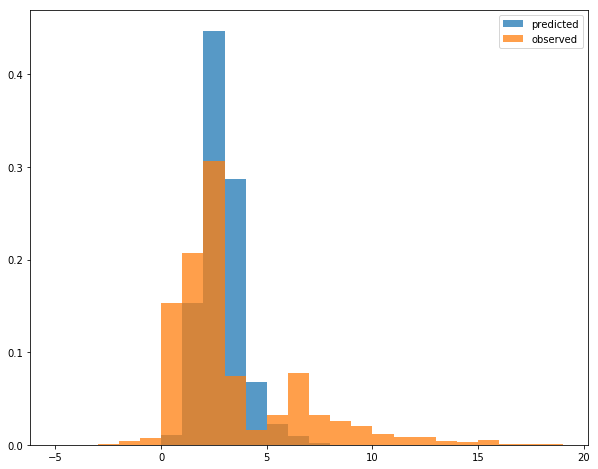

In [237]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_ridge_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

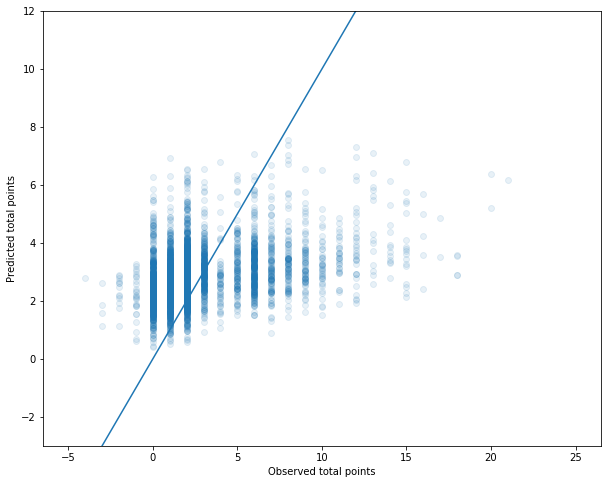

In [173]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(lush_ridge_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Ridge regression (stark)

In [226]:
stark_ridge_model = Ridge(alpha=1e-8)
stark_ridge_model.fit(stark_ridge_X_train_sel, y_train.ravel())

Ridge(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [272]:
# get predictions for test set
stark_ridge_y_pred = stark_ridge_model.predict(stark_ridge_X_test_sel).flatten()

# calculate cross entropy loss for test set
stark_ridge_test_loss = (
    mean_absolute_error(y_test, stark_ridge_y_pred),
    mean_squared_error(y_test, stark_ridge_y_pred),
    r2_score(y_test, stark_ridge_y_pred)
)

stark_ridge_test_loss

(2.1843574261885617, 9.134369923330146, 0.12227090374190164)

In [228]:
pd.Series(stark_ridge_y_pred).describe()

count    948.000000
mean       2.820116
std        1.102348
min       -0.133844
25%        2.190717
50%        2.523808
75%        3.269651
max        8.051378
dtype: float64

In [229]:
# refit stark_ridge_model on all data
stark_ridge_model_full = Ridge(alpha=1e-8)
stark_ridge_model_full.fit(stark_ridge_X_sel, y.ravel())

Ridge(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [264]:
# get predictions for whole set
stark_ridge_y_pred_full = stark_ridge_model_full.predict(stark_ridge_X_sel).flatten()

# calculate cross entropy loss for test set
stark_ridge_test_loss_full = (
    mean_absolute_error(y, stark_ridge_y_pred_full),
    mean_squared_error(y, stark_ridge_y_pred_full),
    r2_score(y, stark_ridge_y_pred_full))
stark_ridge_test_loss_full

(2.087532440803079, 8.276406445562069, 0.13504133015209874)

In [231]:
pd.Series(stark_ridge_y_pred_full).describe()

count    3644.000000
mean        2.869374
std         1.136884
min        -0.957537
25%         2.167992
50%         2.605913
75%         3.317662
max         8.590510
dtype: float64

In [232]:
abs(pd.Series(y.ravel()) - pd.Series(stark_ridge_y_pred_full)).describe()

count    3644.000000
mean        2.087532
std         1.979821
min         0.001586
25%         0.679576
50%         1.503568
75%         2.750284
max        15.284607
dtype: float64

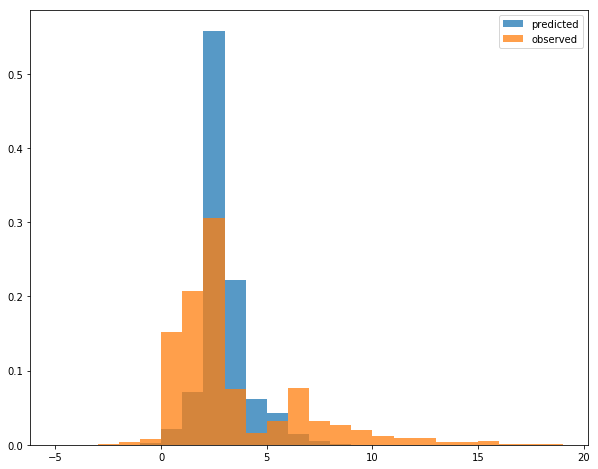

In [236]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_ridge_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

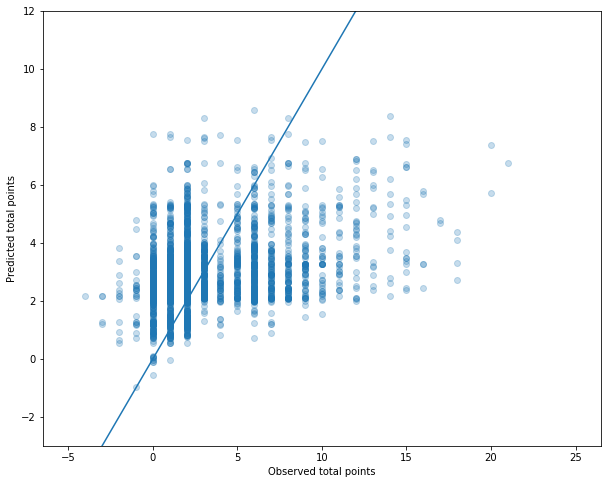

In [234]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(stark_ridge_y_pred_full), alpha=0.25)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Lasso regression

In [212]:
lasso_model = Lasso(alpha=1e-8)
lasso_model.fit(lasso_X_train_sel, y_train.ravel())

Lasso(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [265]:
# get predictions for test set
lasso_y_pred = lasso_model.predict(lasso_X_test_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss = (
    mean_absolute_error(y_test, lasso_y_pred),
    mean_squared_error(y_test, lasso_y_pred),
    r2_score(y_test, lasso_y_pred)
)
lasso_test_loss

(2.2692903162138025, 9.953815571102595, 0.04352969948927987)

In [214]:
pd.Series(lasso_y_pred).describe()

count    948.000000
mean       2.788123
std        0.408607
min        2.046384
25%        2.510950
50%        2.736976
75%        3.001227
max        4.833986
dtype: float64

In [216]:
# refit lasso_model on all data
lasso_model_full = Lasso(alpha=1e-8)
lasso_model_full.fit(lasso_X_sel, y.ravel())

Lasso(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [266]:
# get predictions for whole set
lasso_y_pred_full = lasso_model_full.predict(lasso_X_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss_full = (
    mean_absolute_error(y, lasso_y_pred_full),
    mean_squared_error(y, lasso_y_pred_full),
    r2_score(y, lasso_y_pred_full)
)
lasso_test_loss_full

(2.2175786246427474, 9.191569727898365, 0.03939856289678845)

In [218]:
pd.Series(lasso_y_pred_full).describe()

count    3644.000000
mean        2.869374
std         0.614077
min         1.634404
25%         2.490098
50%         2.781265
75%         3.114555
max         8.524118
dtype: float64

In [219]:
abs(pd.Series(y.ravel()) - pd.Series(lasso_y_pred_full)).describe()

count    3644.000000
mean        2.217579
std         2.067629
min         0.000756
25%         0.818525
50%         1.731793
75%         2.818525
max        17.714659
dtype: float64

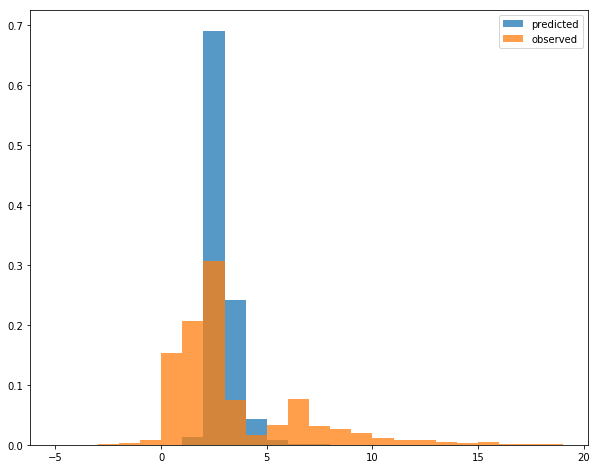

In [235]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lasso_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

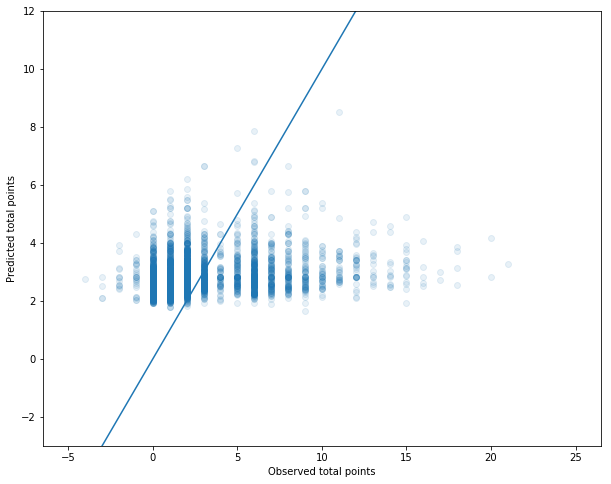

In [222]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(lasso_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [273]:
pd.DataFrame([
    ('Linear regression', lr_test_loss[0], lr_test_loss[1], lr_test_loss[2]),
    ('Ridge regression (lush)', lush_ridge_test_loss[0], lush_ridge_test_loss[1], lush_ridge_test_loss[2]),
    ('Ridge regression (stark)', stark_ridge_test_loss[0], stark_ridge_test_loss[1], stark_ridge_test_loss[2]),
    ('Lasso regression', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear regression,2.368339,10.410214,-0.000326
1,Ridge regression (lush),2.191360,9.339238,0.102585
2,Ridge regression (stark),2.184357,9.134370,0.122271
3,Lasso regression,2.269290,9.953816,0.043530


In [274]:
pd.DataFrame([
    ('Linear regression', lr_test_loss_full[0], lr_test_loss_full[1], lr_test_loss_full[2]),
    ('Ridge regression (lush)', lush_ridge_test_loss_full[0], lush_ridge_test_loss_full[1], lush_ridge_test_loss_full[2]),
    ('Ridge regression (stark)', stark_ridge_test_loss_full[0], stark_ridge_test_loss_full[1], stark_ridge_test_loss_full[2]),
    ('Lasso regression', lasso_test_loss_full[0], lasso_test_loss_full[1], lasso_test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear regression,2.287180,9.551607,0.001771
1,Ridge regression (lush),2.113308,8.380950,0.124116
2,Ridge regression (stark),2.087532,8.276406,0.135041
3,Lasso regression,2.217579,9.191570,0.039399
